file /home/aiops/zhuty/tinyllama/scripts/eval_ppl/results/tiny_LLaMA_1b_8k_cc_8k_tlmcont_chunk_1000_cc_iter-680000-ckpt-step-310000.json Average loss:  2.067758655213019
file /home/aiops/zhuty/tinyllama/scripts/eval_ppl/results/tiny_LLaMA_1b_8k_intramask_cc_8k_tlmcont_chunk_1000_cc_iter-680000-ckpt-step-310000.json Average loss:  2.0508209447610475


<Figure size 640x480 with 0 Axes>

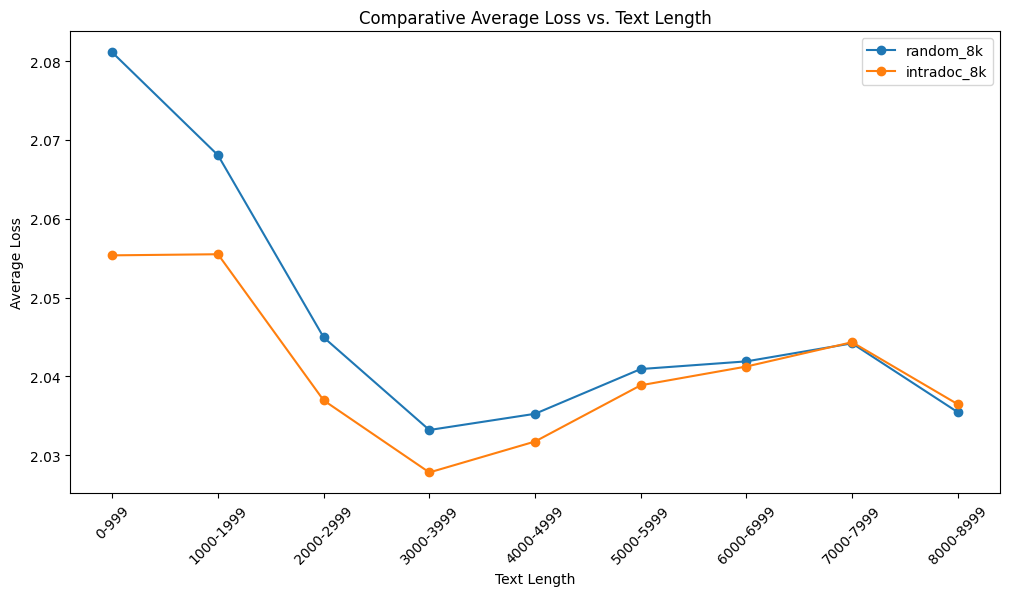

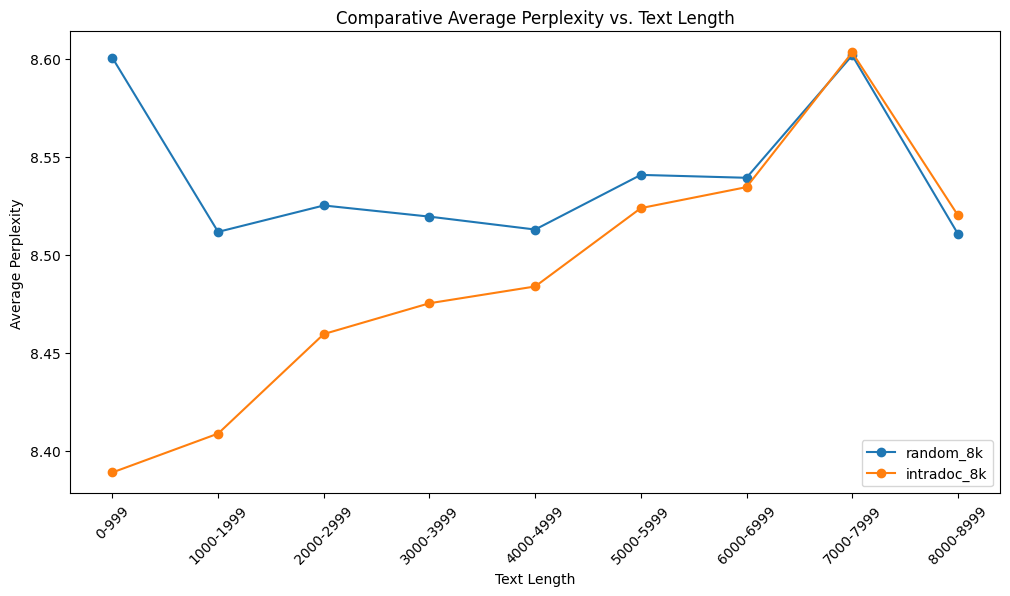

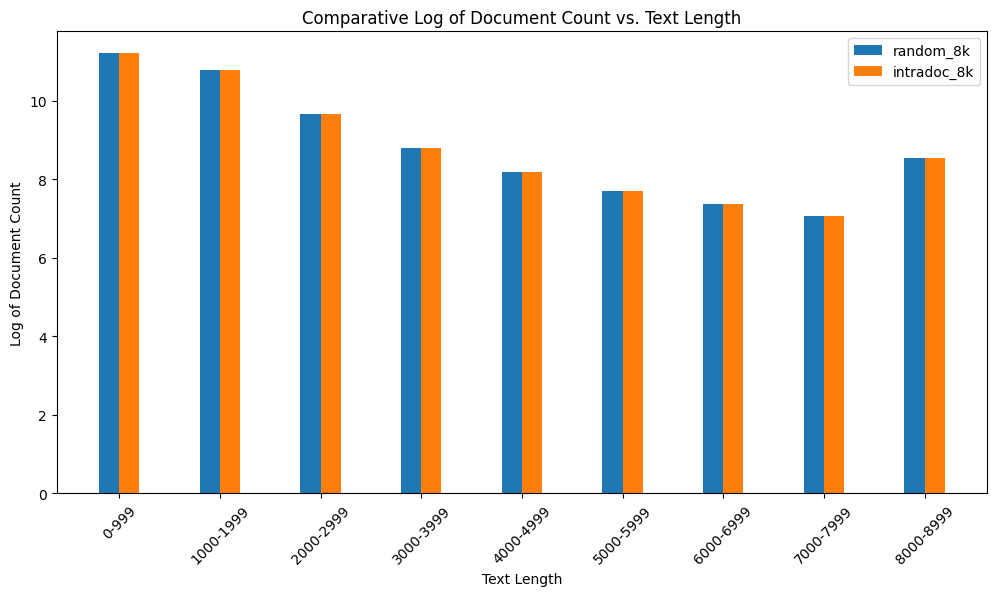

In [5]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_data(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    return pd.DataFrame(data, columns=['length', 'loss'])

def load_data_with_length_threshold(filepath, threshold):
    df = load_data(filepath)
    return df[df['length'] > threshold]

def process_data(data, bin_size=1000):
    # Define bins
    max_length = data['length'].max()
    bins = range(0, max_length + bin_size, bin_size)
    labels = [f"{i}-{i + bin_size - 1}" for i in bins[:-1]]

    # Bin data
    data['bin'] = pd.cut(data['length'], bins=bins, labels=labels, right=False)

    # Calculate statistics for loss
    stats_loss = data.groupby('bin')['loss'].agg(['mean', 'std'])

    # Calculate mean PPL
    data['ppl'] = np.exp(data['loss'])
    stats_ppl = data.groupby('bin')['ppl'].mean().rename('mean_ppl')

    # Calculate the number of documents in each bin
    doc_counts = data['bin'].value_counts().sort_index().rename('doc_count')

    # Combine results
    grouped = pd.concat([stats_loss, stats_ppl, doc_counts], axis=1).reset_index()
    return grouped

def plot_loss(all_grouped_data, model_names, version_to_name={}):
    plt.figure(figsize=(12, 6))
    for grouped_data, model_name in zip(all_grouped_data, model_names):
        plt.plot(grouped_data['bin'], grouped_data['mean'], label=version_to_name.get(model_name, model_name), marker='o', linestyle='-')  # Use a line plot
    plt.xlabel('Text Length')
    plt.ylabel('Average Loss')
    plt.title('Comparative Average Loss vs. Text Length')
    plt.xticks(rotation=45)
    plt.legend()

def plot_ppl(all_grouped_data, model_names, version_to_name={}):
    plt.figure(figsize=(12, 6))
    for grouped_data, model_name in zip(all_grouped_data, model_names):
        plt.plot(grouped_data['bin'], grouped_data['mean_ppl'], label=version_to_name.get(model_name, model_name), marker='o')
    plt.xlabel('Text Length')
    plt.ylabel('Average Perplexity')
    plt.title('Comparative Average Perplexity vs. Text Length')
    plt.xticks(rotation=45)
    plt.legend()

def plot_doc_count(all_grouped_data, model_names):
    plt.figure(figsize=(12, 6))
    width = 0.2  # width of the bars
    for i, (grouped_data, model_name) in enumerate(zip(all_grouped_data, model_names)):
        x = np.arange(len(grouped_data['bin']))  # the label locations
        plt.bar(x + i * width, np.log(grouped_data['doc_count']), width, label=model_name)

    plt.xlabel('Text Length')
    plt.ylabel('Log of Document Count')
    plt.title('Comparative Log of Document Count vs. Text Length')
    plt.xticks(np.arange(len(grouped_data['bin'])) + width / 2 * (len(model_names) - 1), grouped_data['bin'], rotation=45)
    plt.legend()


def main():
    # List of filepaths to your JSON files
    # versions = ['cc_v4_8k', 'cc_v42_8k', 'intramask_cc_v4_8k', 'intramask_cc_v42_8k']
    # versions_to_names = {'cc_v4_8k': 'random', 'cc_v42_8k': 'bm25', 'intramask_cc_v4_8k': 'intramask', 'intramask_cc_v42_8k': 'intramask_bm25'}
    # versions = ['cc_16k_intracccont3','cc_merged_v2_16k', 'intramask_cc_16k', 'intramask_cc_merged_v2_16k', 'adamask_cc_merged_v2_16k',]
    # versions = ['cc_16k_intracccont3', 'cc_merged_v2_16k_intracccont3', 'intramask_cc_16k_intracccont3', 'intramask_cc_merged_v2_16k_intracccont3', 'adamask_cc_merged_v2_16k_intracccont3',]
    versions = ['cc_8k_tlmcont', 'intramask_cc_8k_tlmcont']
    # versions = ['cc_16k_tlmcont', 'intramask_cc_16k_tlmcont']
    # versions_to_names = {'cc_16k_intracccont3': 'random_16k', 'cc_merged_v2_16k_intracccont3': 'bm25_16k', 'intramask_cc_16k_intracccont3': 'intradoc', 'intramask_cc_merged_v2_16k_intracccont3': 'intradoc(bm25)', 'adamask_cc_merged_v2_16k_intracccont3': 'adamask(bm25)'}
    versions_to_names = {'cc_8k_tlmcont': 'random_8k', 'intramask_cc_8k_tlmcont': 'intradoc_8k'}
    # versions_to_names = {'cc_16k_tlmcont': 'random_16k', 'intramask_cc_16k_tlmcont': 'intradoc_16k'}


    # step = 310000
    step = 310000
    ds = "_cc"
    size = '1b'
    # iter = f"_iter-{step*8:06}-ckpt-step-{step}"
    iter = f"_iter-{680000}-ckpt-step-{step}"
    # iter = f"_iter-{640000}-ckpt-step-{step}"
    window_size = '8k'
    filepaths = [f'/home/aiops/zhuty/tinyllama/scripts/eval_ppl/results/tiny_LLaMA_{size}_{window_size}_{version}_chunk_1000{ds}{iter}.json' for version in versions]

    model_names = [versions_to_names.get(version, version) for version in versions]
    all_grouped_data = []
    for filepath in filepaths:
        data = load_data(filepath)
        print("file", filepath, "Average loss: ", data['loss'].mean())
        grouped_data = process_data(data)
        all_grouped_data.append(grouped_data)
    plt.subplots_adjust(hspace=0.5)
    plot_loss(all_grouped_data, model_names, version_to_name=versions_to_names)
    plot_ppl(all_grouped_data, model_names, version_to_name=versions_to_names)
    plot_doc_count(all_grouped_data, model_names)



def plot_average_loss_against_steps():
    versions = ['cc_16k_intracccont3', 'cc_merged_v2_16k_intracccont3', 'intramask_cc_16k_intracccont3', 'intramask_cc_merged_v2_16k_intracccont3', 'adamask_cc_merged_v2_16k_intracccont3',]
    versions_to_names = {'cc_16k_intracccont3': 'random_16k', 'cc_merged_v2_16k_intracccont3': 'bm25_16k', 'intramask_cc_16k_intracccont3': 'intradoc', 'intramask_cc_merged_v2_16k_intracccont3': 'intradoc(bm25)', 'adamask_cc_merged_v2_16k_intracccont3': 'adamask(bm25)'}


    for ds in ['_arxiv', '_rpwiki_en', "_book", "_cc"]:
        row_dicts = []
        for step in range(80000, 95000, 5000):
            size = '1b'
            iter = f"_iter-{step*8:06}-ckpt-step-{step}"
            window_size = '16k'

            model_names = [versions_to_names.get(version, version) for version in versions]
            for version in versions:
                filepath = f'/home/aiops/zhuty/tinyllama/scripts/eval_ppl/results/tiny_LLaMA_{size}_{window_size}_{version}_chunk_1000{ds}{iter}.json'
                data = load_data_with_length_threshold(filepath, threshold=8192)
                print("file", filepath, "number of documents", len(data), "Average loss: ", data['loss'].mean())
                row_dicts.append({'version': version, 'step': step, 'loss': data['loss'].mean()})
        df = pd.DataFrame(row_dicts)
        print(df)

        plt.figure(figsize=(12, 6))
        for version in versions:
            plt.plot(df[df['version'] == version]['step'], df[df['version'] == version]['loss'], label=versions_to_names[version], marker='o', linestyle='-')  # Use a line plot
        plt.xlabel('Step')
        plt.ylabel('Average Loss')
        plt.legend()
        plt.title(f'Comparative Average Loss vs. Step{ds} for {ds}')



if __name__ == "__main__":
    main()


In [15]:
import json
dir = '/home/aiops/zhuty/tinyllama/scripts/fewshot_eval/outputs/tiny_LLaMA_1b_8k_cc_merged_v2_8k-iter-600000-ckpt-step-75000_hf'
file = 'sst2_12_57_prompts_and_preds.json'
data = json.load(open(f'{dir}/{file}', 'r'))

In [18]:
data['prompts'][0]

{'prompt': "text: A waterlogged version of ` Fatal Attraction ' for the teeny-bopper set ... a sad , soggy potboiler that wastes the talents of its attractive young leads . sentiment: negative\n\ntext: For all its violence , the movie is remarkably dull with only Caine making much of an impression . sentiment: negative\n\ntext: The actors are fantastic . sentiment: positive\n\ntext: It 's nice to see Piscopo again after all these years , and Chaykin and Headly are priceless . sentiment: positive\n\ntext: Scarcely worth a mention apart from reporting on the number of tumbleweeds blowing through the empty theatres graced with its company . sentiment: negative\n\ntext: A three-hour cinema master class . sentiment: positive\n\ntext: Visually , ` Santa Clause 2 ' is wondrously creative . sentiment: positive\n\ntext: Well-made but mush-hearted . sentiment: positive\n\ntext: A fun ride . sentiment: positive\n\ntext: The plot grows thin soon , and you find yourself praying for a quick resoluti

In [ ]:
# step = 47500
# step = 75000
step = 75000
# versions = ['cc_merged_v2_8k', 'intramask_cc_8k', 'intramask_cc_merged_v2_8k', 'adamask_cc_merged_v2_8k', 'cc_merged_v2_8k_intrav2cont','cc_8k',]
# step = 65000
size = '1b'
# versions = ['cc_merged_v2_8k', 'intramask_cc_8k', 'intramask_cc_merged_v2_8k', 'adamask_cc_merged_v2_8k', 'cc_merged_v2_8k_intracccont','cc_8k',]
versions = ['cc_merged_v2_8k', 'intramask_cc_8k', 'cc_merged_v1_8k', 'adamask_cc_merged_v2_8k',
            'cc_merged_v2_8k_intracccont', 'cc_8k', ]

for model_name in versions:
    if size == '360M':
        path = f"/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_360M_8k_{model_name}/iter-{step * 4}-ckpt-step-{step}.pth"
    elif size == '1b':
        path = f"/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_8k_{model_name}/iter-{step * 8}-ckpt-step-{step}.pth"
    if not os.path.exists(path):
        print(f"model {model_name} not found")
    # elif os.path.exists(f"/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_360M_8k_{model_name}/iter-{step*4}-ckpt-step-{step}_hf/config.json"):
    elif (size == '360M' and os.path.exists(
            f"/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_360M_8k_{model_name}/iter-{step * 4}-ckpt-step-{step}_hf/config.json")) or (
            size == '1b' and os.path.exists(
            f"/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_8k_{model_name}/iter-{step * 8}-ckpt-step-{step}_hf/config.json")):
        print(f"model {model_name} already converted")
    else:
        # print(f"bash convert_to_hf_general.sh /home/aiops/zhuty/tinyllama/out/tiny_LLaMA_360M_8k_intramask_cc_merged_v2_8k iter-160000-ckpt-step-40000")
        # print(f"bash convert_to_hf_general.sh /home/aiops/zhuty/tinyllama/out/tiny_LLaMA_360M_8k_{model_name} iter-{step*4}-ckpt-step-{step}")
        # print(f"bash convert_to_hf_general.sh /home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_8k_{model_name} iter-{step*8}-ckpt-step-{step}")'
        if size == '360M':
            print(
                f"bash convert_to_hf_general.sh /home/aiops/zhuty/tinyllama/out/tiny_LLaMA_360M_8k_{model_name} iter-{step * 4}-ckpt-step-{step}")
        elif size == '1b':
            print(
                f"bash convert_to_hf_general.sh /home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_8k_{model_name} iter-{step * 8}-ckpt-step-{step}")



In [7]:
import torch

In [24]:
def add_fixed_length_attention_mask(example, region_length):
    labels = example["label"]
    # Initialize the attention mask with zeros
    attention_mask = torch.zeros_like(labels)

    # Identify positions with labels not equal to -100
    valid_positions = (labels != -100).nonzero(as_tuple=True)[0]

    # Create a running index to segment the valid positions
    running_index = torch.arange(1, len(valid_positions) // region_length + 2)

    # Assign region values to the attention mask
    for i, start in enumerate(range(0, len(valid_positions), region_length)):
        end = min(start + region_length, len(valid_positions))
        attention_mask[valid_positions[start:end]] = running_index[i]

    return attention_mask

In [26]:
example = {'label': torch.tensor([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,-100,-100])}
region_length = 6
add_fixed_length_attention_mask(example, region_length)

tensor([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 0, 0])